In [2]:
# Run this first to ensure packages are installed
!pip install -q scikit-learn pandas matplotlib joblib kaggle


In [3]:
# Upload kaggle.json if you didn't upload via the file browser
from google.colab import files
uploaded = files.upload()  # choose kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
# move kaggle.json to the correct location and set permissions
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download the dataset (clmentbisaillon/fake-and-real-news-dataset)
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset -q
!unzip -o fake-and-real-news-dataset.zip -d /content/fake_news_dataset
!ls -la /content/fake_news_dataset


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
Archive:  fake-and-real-news-dataset.zip
  inflating: /content/fake_news_dataset/Fake.csv  
  inflating: /content/fake_news_dataset/True.csv  
total 113656
drwxr-xr-x 2 root root     4096 Oct 22 11:54 .
drwxr-xr-x 1 root root     4096 Oct 22 11:54 ..
-rw-r--r-- 1 root root 62789876 Apr 19  2024 Fake.csv
-rw-r--r-- 1 root root 53582940 Apr 19  2024 True.csv


In [5]:
# imports
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [6]:
# load the CSVs (path depends on how you downloaded them)
# Option A: Kaggle created folder:
try:
    true_df = pd.read_csv('/content/fake_news_dataset/True.csv')
    fake_df = pd.read_csv('/content/fake_news_dataset/Fake.csv')
except Exception as e:
    # Option B: uploaded to /content
    true_df = pd.read_csv('/content/True.csv')
    fake_df = pd.read_csv('/content/Fake.csv')

print("True:", true_df.shape)
print("Fake:", fake_df.shape)


True: (21417, 4)
Fake: (23481, 4)


Inspect & combine dataset

In [7]:
# Quick peek
display(true_df.head(2))
display(fake_df.head(2))

# Ensure columns: some datasets have 'text' column named differently (e.g., 'text' or 'title' + 'text')
# For this dataset, column 'text' exists. If not, adjust column names accordingly.
for df in [true_df, fake_df]:
    print(df.columns)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [8]:
# Create label: 1 -> real/true, 0 -> fake
true_df['label'] = 1
fake_df['label'] = 0

# Some rows may have Title + Text; we'll combine title + text to form the article text (safer)
def combine_row(r):
    t = ''
    if 'title' in r and pd.notna(r['title']):
        t += str(r['title']) + ' '
    if 'text' in r and pd.notna(r['text']):
        t += str(r['text'])
    return t.strip()

true_df['content'] = true_df.apply(combine_row, axis=1)
fake_df['content'] = fake_df.apply(combine_row, axis=1)

# Combine and shuffle
df = pd.concat([true_df[['content','label']], fake_df[['content','label']]], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined shape:", df.shape)
df.head(3)


Combined shape: (44898, 2)


,content,label
0,BREAKING: GOP Chairman Grassley Has Had Enough...,0
1,Failed GOP Candidates Remembered In Hilarious ...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY ...,0


Basic text cleaning

In [9]:
# Simple cleaning function
def clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # remove non-ascii
    text = text.encode('ascii', errors='ignore').decode()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove digits
    text = re.sub(r'\d+', '', text)
    # strip extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean'] = df['content'].apply(clean_text)
df = df[df['clean'].str.len() > 20]  # drop extremely short rows
print("After cleaning:", df.shape)
df.head(3)


After cleaning: (44889, 3)


,content,label,clean
0,BREAKING: GOP Chairman Grassley Has Had Enough...,0,breaking gop chairman grassley has had enough ...
1,Failed GOP Candidates Remembered In Hilarious ...,0,failed gop candidates remembered in hilarious ...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY ...,0,mike pences new dc neighbors are hilariously t...


Train-test split

In [10]:
X = df['clean']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (33666,) Test: (11223,)


TF-IDF vectorization

In [11]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=3, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (33666, 512651) (11223, 512651)


Train Multinomial Naive Bayes

In [12]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


MultinomialNB()

Evaluate

Accuracy: 96.03%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5868
           1       0.96      0.96      0.96      5355

    accuracy                           0.96     11223
   macro avg       0.96      0.96      0.96     11223
weighted avg       0.96      0.96      0.96     11223



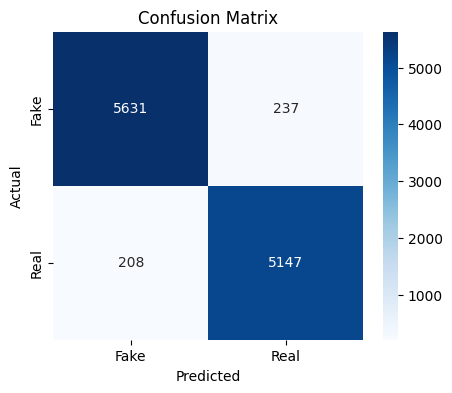

In [13]:
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Save model and vectorizer

In [14]:
# Save to files
joblib.dump(model, 'naive_bayes_fake_news_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# If you'd like to download them locally:
from google.colab import files
files.download('naive_bayes_fake_news_model.pkl')
files.download('tfidf_vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Helper functions: predict single article and show top features

In [15]:
def predict_text(text):
    clean = clean_text(text)
    v = tfidf.transform([clean])
    pred = model.predict(v)[0]
    proba = model.predict_proba(v)[0]
    return {'prediction': 'Real' if pred==1 else 'Fake', 'prob_real': float(proba[1]), 'prob_fake': float(proba[0])}

# Example:
sample = "Breaking news: Scientists discover a new particle that solves climate change immediately."
print(predict_text(sample))


{'prediction': 'Fake', 'prob_real': 0.1436195800928488, 'prob_fake': 0.8563804199071525}


In [16]:
# Show top positive/negative features for class 0 (fake) and class 1 (real)
def top_n_features_for_class(clf, vec, class_index, n=20):
    feature_names = np.array(vec.get_feature_names_out())
    class_log_probs = clf.feature_log_prob_[class_index]
    topn = np.argsort(class_log_probs)[-n:]
    return feature_names[topn][::-1]

print("Top words for REAL:", top_n_features_for_class(model, tfidf, 1, 15))
print("Top words for FAKE:", top_n_features_for_class(model, tfidf, 0, 15))


Top words for REAL: ['trump' 'reuters' 'president' 'house' 'state' 'government' 'states'
 'republican' 'united' 'north' 'new' 'trumps' 'washington' 'korea'
 'senate']
Top words for FAKE: ['trump' 'video' 'clinton' 'obama' 'hillary' 'people' 'just' 'president'
 'like' 'donald' 'donald trump' 'news' 'white' 'america' 'black']


Notebook polish (optional): add markdown cells explaining each step, visualize class balance

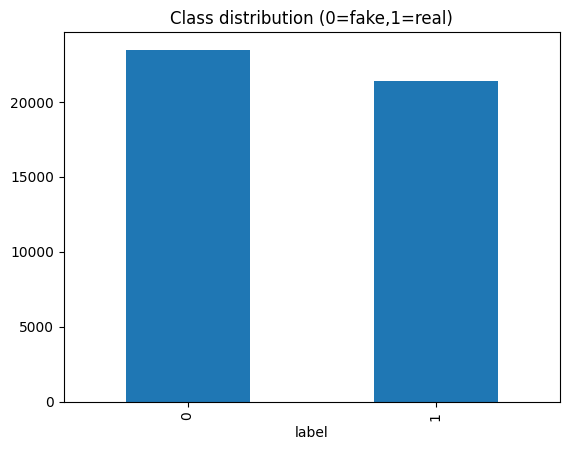

In [17]:
# Class distribution
df['label'].value_counts().plot(kind='bar', title='Class distribution (0=fake,1=real)');
plt.show()
